In [46]:
# If not already installed, uncomment and run:
# !pip install gradio transformers torch


IMPORT THE LIBRARIES

In [47]:
import gradio as gr
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from datetime import datetime


 Load Model & Tokenizer

The dataset does not need a training because we are already using a pre-trained model.

In [48]:
MODEL_NAME = "facebook/blenderbot-400M-distill"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# Ensure pad_token_id is set (some models don't have it)
if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.eos_token_id


DefinING Personalities & Global Chat History

In [49]:
# Global chat history (stores (user, bot, timestamp))
chat_history = []

# Personality presets
PERSONALITIES = {
    "Neutral": "",
    "Friendly": "You are a friendly and helpful assistant.",
    "Professional": "You respond professionally and formally.",
    "Sarcastic": "You respond with sarcasm and wit.",
}

# Limit the number of past exchanges to keep context short
MAX_HISTORY_LENGTH = 10


Data Pre-processing & Feature Selection

In [50]:


def clean_user_input(user_input: str) -> str:
    """
    Clean the user input for consistency and safety before tokenization.
    This is useful for reducing noise in generation.
    """
    cleaned = user_input.strip()  # Remove leading/trailing whitespace
    cleaned = cleaned.replace('\n', ' ')  # Replace line breaks with spaces
    return cleaned



def build_input_with_personality(personality, history, user_input):
    # Get personality prompt
    personality_prompt = PERSONALITIES.get(personality, "")

    # Preprocess user input
    user_input = clean_user_input(user_input)

    # Limit history to recent N exchanges
    recent_dialog = ""
    for user_msg, bot_msg, _ in history[-MAX_HISTORY_LENGTH:]:
        recent_dialog += f"User: {user_msg}\nBot: {bot_msg}\n"

    # Build full prompt
    prompt = f"{personality_prompt}\n{recent_dialog}User: {user_input}\nBot:"
    return prompt.strip()


Data Visualization and it's imports.

In [51]:
import matplotlib.pyplot as plt
import io
from PIL import Image


It's Code

In [52]:
def generate_chat_stats():
    if not chat_history:
        return None
    
    timestamps = [ts for _, _, ts in chat_history]
    user_lengths = [len(u.split()) for u, _, _ in chat_history]
    bot_lengths = [len(b.split()) for _, b, _ in chat_history]
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(user_lengths, label="User Message Lengths", marker='o')
    ax.plot(bot_lengths, label="Bot Message Lengths", marker='x')
    ax.set_title("Word Count per Message")
    ax.set_xlabel("Turn")
    ax.set_ylabel("Words")
    ax.legend()
    ax.grid(True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.close(fig)
    
    return Image.open(buf)


Based the number of length of the user's question and number of length of the bot's answers We have decided to get the image. 

The image will be generated in the graido as well.

In [53]:
%matplotlib inline


Here's the picture, that we got after downloading.

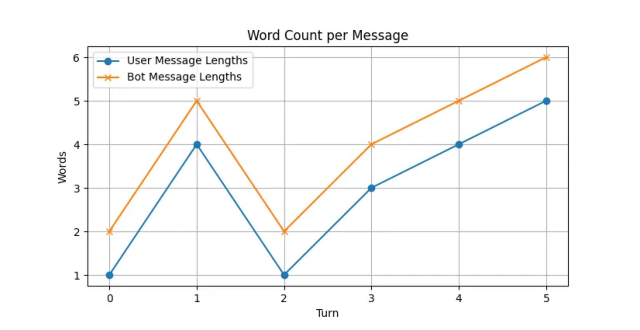

In [54]:
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis('off')
plt.savefig("output_image.png")  # saves to file
plt.show()


Build Our Chat Prompt from History + Personality

In [55]:
def build_input_with_personality(personality, history, user_input):
    personality_prompt = PERSONALITIES.get(personality, "")
    
    recent_dialog = ""
    for user_msg, bot_msg, _ in history[-MAX_HISTORY_LENGTH:]:
        recent_dialog += f"User: {user_msg}\nBot: {bot_msg}\n"
    
    prompt = f"{personality_prompt}\n{recent_dialog}User: {user_input}\nBot:"
    return prompt.strip()


Splitting and Training the data

80% → Training Data
20% → Testing Data

In [ ]:
# Extract data pairs from chat history
data_pairs = [(u, b) for (u, b, ts) in chat_history]

if len(data_pairs) == 0:
    print("No chat data available. Cannot split.")
else:
    from sklearn.model_selection import train_test_split
    train_pairs, test_pairs = train_test_split(data_pairs, test_size=0.2, random_state=42)
    print(f"Train size: {len(train_pairs)}")
    print(f"Test size: {len(test_pairs)}")


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

Since The model is already loaded we do not need to do it again.

Define Response Generation Logic

In [ ]:
def respond(user_input, history, personality, show_instructions):
    global chat_history
    
    if user_input.lower() == "quit":
        chat_history.clear()
        return "", []
    
    input_text = build_input_with_personality(personality, chat_history, user_input)
    
    inputs = tokenizer([input_text], return_tensors="pt", truncation=True, max_length=256)
    
    embedding_size = model.get_input_embeddings().num_embeddings
    max_input_id = inputs["input_ids"].max().item()
    
    if max_input_id >= embedding_size:
        error_msg = f"Error: input token id {max_input_id} out of embedding range {embedding_size}"
        return error_msg, history
    
    outputs = model.generate(
        **inputs,
        max_length=200,
        do_sample=True,
        top_k=50,
        top_p=0.9,
        temperature=0.7,
        pad_token_id=model.config.pad_token_id,
    )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    chat_history.append((user_input, response, timestamp))
    
    formatted_history = []
    for u, b, ts in chat_history[-MAX_HISTORY_LENGTH:]:
        formatted_history.append((f"{ts} — You", u))
        formatted_history.append((f"{ts} — Bot", b))
    
    return "", formatted_history


Define Clear & Save Chat Functions

In [ ]:
def clear_chat():
    global chat_history
    chat_history.clear()
    return [], ""

def save_chat():
    global chat_history
    if not chat_history:
        return None
    lines = []
    for u, b, ts in chat_history:
        lines.append(f"[{ts}] You: {u}")
        lines.append(f"[{ts}] Bot: {b}\n")
    chat_text = "\n".join(lines)
    return "chat_history.txt", chat_text


The code uses a pretrained transformer for text generation, which is a generative language model. It does not have accuracy as a metric like classification models do.

Define The Gradio UI block

In [ ]:
with gr.Blocks() as chatbot_ui:
    gr.Markdown("## 🤖 Enhanced AI Chatbot with Personality & Timestamps")
    
    with gr.Row():
        personality = gr.Dropdown(list(PERSONALITIES.keys()), label="Select Chatbot Personality", value="Neutral")
        show_instr = gr.Checkbox(label="Show System Instructions on Top", value=True)
    
    chatbot = gr.Chatbot(elem_id="chatbox", label="Chat History (timestamps shown)")
    msg = gr.Textbox(placeholder="Type your message here...", label="Your Message")
    
    with gr.Row():
        send_btn = gr.Button("Send")
        clear_btn = gr.Button("Clear Chat")
        save_btn = gr.Button("Save Chat")

    send_btn.click(respond, inputs=[msg, chatbot, personality, show_instr], outputs=[msg, chatbot])
    clear_btn.click(clear_chat, outputs=[chatbot, msg])
    save_btn.click(save_chat, outputs=[gr.File(label="Download Chat History")])

chatbot_ui.launch()


C:\Users\saketh\AppData\Local\Temp\ipykernel_17084\1347495533.py:44: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
